# Принятие решений в бизнесе: проект

В рамках проекта мы оказываем поддержку отделу маркетинга крупного интернет-магазина для увеличения выручки. Работа будет выполнена в два этапа: приоритизация гипотез и анализ результатов A/B-теста.

---

## Этап. Приоритизация гипотез

На первом этапе мы оценим девять предложенных гипотез по увеличению выручки. Для этого будут использованы фреймворки **ICE** и **RICE**, что позволит определить приоритеты для внедрения гипотез. 

**Задачи этапа:**
- Оценка гипотез с использованием ICE и RICE.
- Сравнение результатов приоритизации по обоим методам.
- Анализ различий между результатами методов.

---

## Этап. Анализ A/B-теста

**На втором этапе мы проведём анализ результатов проведённого A/B-теста. Работа будет включать:**

1. Построение ключевых графиков, отражающих изменения кумулятивных метрик:
   - выручки;
   - среднего чека;
   - конверсии.

2. Выявление аномалий среди пользователей и заказов с помощью статистических методов.

3. Проведение тестов на статистическую значимость различий между группами:
   - на сырых данных;
   - на очищенных данных.

4. Принятие обоснованного решения о дальнейших действиях на основе результатов теста.

---

## Итоги проекта

Результатом работы станут:
- **Рекомендации** по приоритетным гипотезам.
- **Заключение** о результатах A/B-теста, которое поможет компании выбрать дальнейший курс действий для увеличения выручки.


# Описание данных

**Файл `hypothesis.csv`** 
- **Hypothesis** — краткое описание гипотезы.
- **Reach** — охват пользователей по 10-балльной шкале.
- **Impact** — влияние на пользователей по 10-балльной шкале.
- **Confidence** — уверенность в гипотезе по 10-балльной шкале.
- **Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение `Efforts`, тем дороже проверка гипотезы.

---

**Файл `orders.csv`**
- **transactionId** — идентификатор заказа.
- **visitorId** — идентификатор пользователя, совершившего заказ.
- **date** — дата, когда был совершён заказ.
- **revenue** — выручка заказа.
- **group** — группа A/B-теста, в которую попал заказ.

---

**Файл `visitors.csv`**
- **date** — дата.
- **group** — группа A/B-теста.
- **visitors** — количество пользователей в указанную дату в указанной группе A/B-теста.


# **Этап 1. Приоритизация гипотез**


**Начнём с обзора и предобработки данных:**

In [1]:
# импорт необходимых для работы библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import warnings
from scipy import stats as st
from scipy.stats import mannwhitneyu

In [2]:
# снимаем ограничение на количество столбцов
pd.set_option('display.max_columns', None)

# снимаем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', None)

# игнорируем предупреждения
warnings.filterwarnings(action='ignore')

# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format

# задаем размер графика
sns.set(rc={'figure.figsize':(10,8)})

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [4]:
def inspect_df(*dataframes, head_rows=5):
    
    for i, df in enumerate(dataframes):
        print(f"--- DataFrame {i + 1} ---")
        
        # Выводим общую информацию
        print("Информация о данных:")
        df.info()
        print("\n")
        
        # Выводим первые строки датафрейма
        print(f"Первые {head_rows} строк:")
        print(df.head(head_rows))
        print("\n")
        
        # Проверяем на наличие дубликатов
        duplicate_count = df.duplicated().sum()
        print(f"Количество дубликатов: {duplicate_count}\n")
        
        # Если есть дубликаты, выводим сообщение
        if duplicate_count > 0:
            print(f"В DataFrame {i + 1} обнаружены дубликаты.\n")
        
        print("\n=============================\n")


In [5]:
inspect_df(hypothesis, orders, visitors, head_rows=5)

--- DataFrame 1 ---
Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Первые 5 строк:
                                                                                                     Hypothesis  \
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
3           Изменить структура категорий, что 

In [6]:
# изменим тип данных для столбцов с датами
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [7]:
# Приведение названий столбцов к змеиному формату

# Для hypothesis: все буквы — в нижний регистр
hypothesis.columns = hypothesis.columns.str.lower()

# Для orders: заменяем "Id" в названиях столбцов на "_id" для более унифицированного стиля
orders.columns = [col.replace('Id', '_id') for col in orders.columns]

display(hypothesis.columns)
orders.columns


Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

**Приступим к приоритезации гипотез:**

In [8]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).head(5)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000


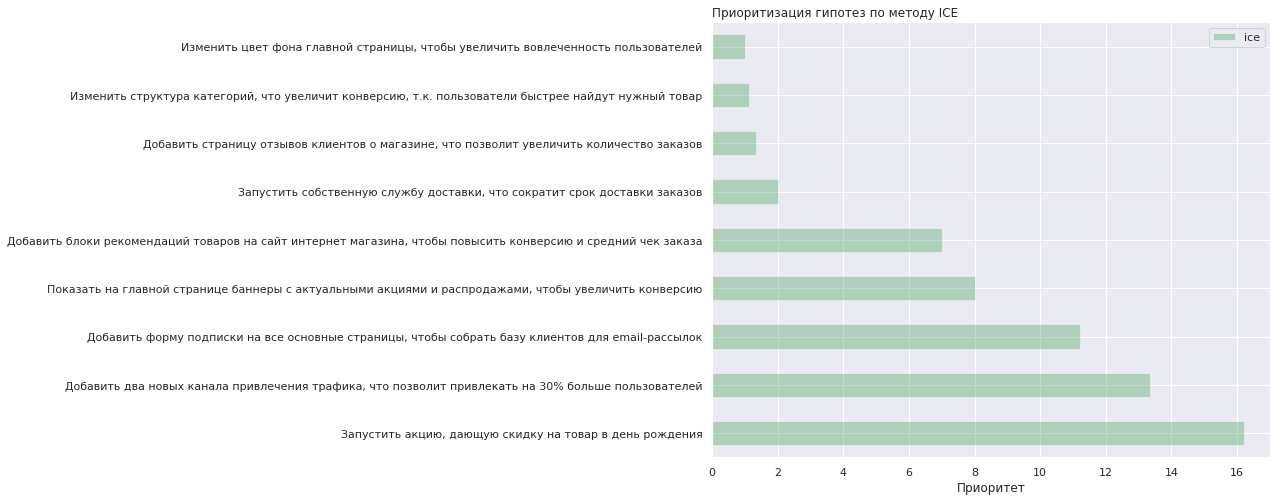

In [9]:
# Построение горизонтальной гистограммы для визуализации приоритизации гипотез по ICE
ax = (hypothesis[['hypothesis', 'ice']]
      .set_index('hypothesis')
      .sort_values('ice', ascending=False)
      .plot(kind='barh', color='g', alpha=0.4))

ax.grid(True)

ax.set_xlabel('Приоритет')
ax.set_ylabel('')

ax.set_title('Приоритизация гипотез по методу ICE', loc='left')

plt.show()

In [10]:
# Расчёт приоритета гипотез по методу RICE
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * 
                      hypothesis['confidence'] / hypothesis['efforts'])

# Отображаем топ-5 гипотез с самым высоким приоритетом по RICE
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False).head(5)


,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200


In [11]:
hypothesis[['hypothesis','ice', 'rice']].sort_values(by='rice', ascending=False).head(5)

,hypothesis,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200,112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000,56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333,40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000,40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200,16.200


**Вывод:**
**Метод ICE**  
Наибольший приоритет у гипотезы 8, предлагающей скидку на день рождения. Гипотезы 0, 7, 6 и 2 также имеют высокий приоритет.

**Метод RICE**  
У гипотезы 7 максимальный приоритет благодаря большому охвату. Гипотезы 2, 0, 6 и 8 поменяли свои позиции в сравнении с ICE из-за учёта охвата (Reach).


Учет охвата в методе RICE существенно изменил порядок приоритизации гипотез. Гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" занимает первое место при учете охвата, тогда как гипотеза "Запустить акцию, дающую скидку на товар в день рождения" была лидером в методе ICE.


# Этап 2. Анализ A/B-теста


In [12]:
# Сформируем массив уникальных комбинаций дат и групп теста
unique_dates_groups = orders[['date', 'group']].drop_duplicates()

# Посчитаем накопленные метрики по дням для каждой группы
cumulative_orders = unique_dates_groups.apply(
    lambda row: orders[
        (orders['date'] <= row['date']) & (orders['group'] == row['group'])
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

cumulative_orders.head(5)


,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [13]:
# Сформируем агрегированные кумулятивные данные по дням для посетителей интернет-магазина

cumulative_visitors = unique_dates_groups.apply(
    lambda row: visitors[
        (visitors['date'] <= row['date']) & (visitors['group'] == row['group'])
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'visitors': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

cumulative_visitors.head(5)


,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [14]:
# Объединим кумулятивные данные по заказам и посетителям в одну таблицу

cumulative_data = cumulative_orders.merge(
    cumulative_visitors,
    left_on=['date', 'group'],
    right_on=['date', 'group']
)

cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# Конверсия: отношение числа заказов к количеству посетителей
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

cumulative_data.head(5)


,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033
1,2019-08-01,B,21,20,101217,713,0.029
2,2019-08-02,A,44,38,242401,1338,0.033
3,2019-08-02,B,45,43,266748,1294,0.035
4,2019-08-03,A,68,62,354874,1845,0.037


**Построим график кумулятивной выручки:**

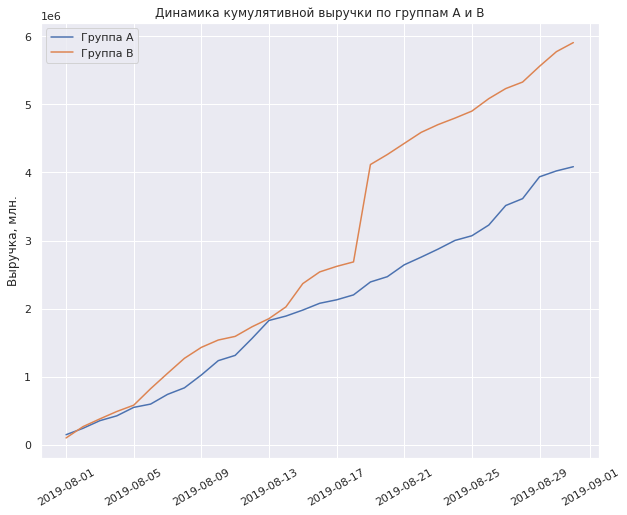

In [15]:
cumulative_revenue_a = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]

cumulative_revenue_b = cumulative_data[cumulative_data['group'] == 'B'][['date', 'revenue', 'orders']]

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='Группа A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='Группа B')

plt.title('Динамика кумулятивной выручки по группам A и B')
plt.ylabel('Выручка, млн.')
plt.xticks(rotation=30)
plt.legend()
plt.show()


По графику видно, что кумулятивная выручка группы B стабильно выше группы A. В группе B наблюдается резкий скачок выручки около 18 августа, что может быть связано с крупными заказами или выбросами в данных.

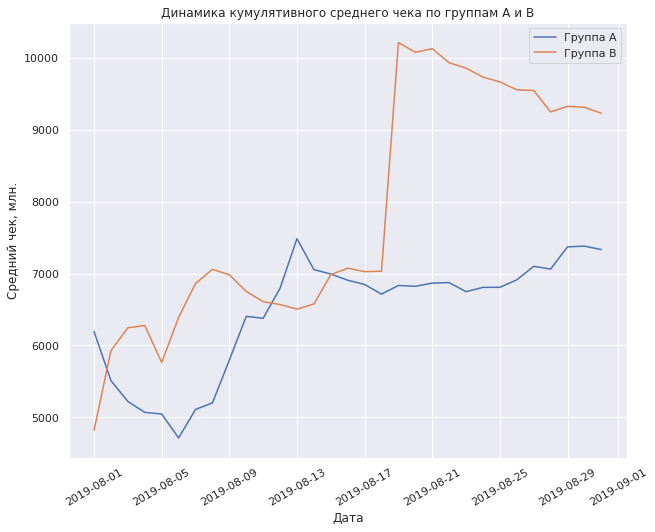

In [16]:
# Построение графика среднего чека по группам
plt.plot(
    cumulative_revenue_a['date'], 
    cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'], 
    label='Группа A'
)

plt.plot(
    cumulative_revenue_b['date'], 
    cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'], 
    label='Группа B'
)

plt.title('Динамика кумулятивного среднего чека по группам A и B')
plt.ylabel("Средний чек, млн.")
plt.xlabel("Дата")
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.show()


На графике видно, что кумулятивный средний чек в группе A остается относительно стабильным после начальных колебаний, тогда как в группе B наблюдается резкий скачок 17–18 августа. Это указывает на наличие крупного заказа или выброса в данных. После скачка средний чек в группе B постепенно снижается, но остается выше, чем в группе A. 

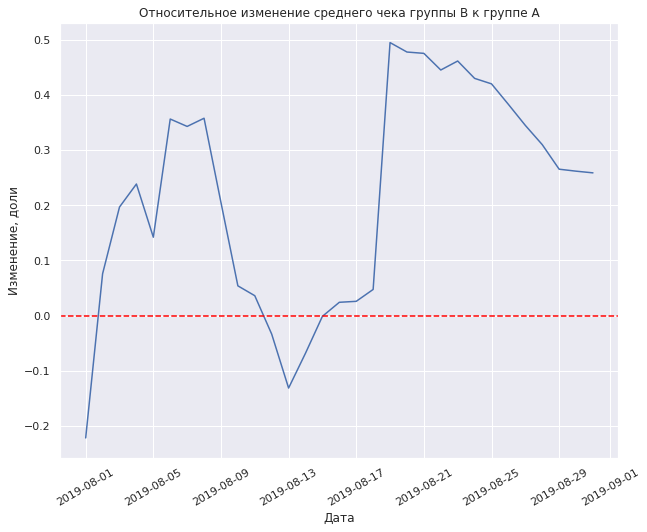

In [17]:
# Объединение данных о кумулятивной выручке и заказах для групп A и B
cumulative_revenue_combined = cumulative_revenue_a.merge(
    cumulative_revenue_b, 
    on='date', 
    how='left', 
    suffixes=['_a', '_b']
)

# Построение графика относительного изменения среднего чека группы B к группе A
plt.plot(
    cumulative_revenue_combined['date'], 
    (
        cumulative_revenue_combined['revenue_b'] / cumulative_revenue_combined['orders_b']
    ) /
    (
        cumulative_revenue_combined['revenue_a'] / cumulative_revenue_combined['orders_a']
    ) - 1,
    label='Относительное изменение'
)

# Добавление горизонтальной линии на уровне 0
plt.axhline(y=0, color='red', linestyle='--')

plt.title('Относительное изменение среднего чека группы B к группе A')
plt.ylabel('Изменение, доли')
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.grid(True)
plt.show()


График показывает значительные колебания относительного изменения среднего чека группы B по сравнению с группой A. Особенно заметны резкие скачки, что, вероятно, связано с выбросами или крупными заказами в группе B. 

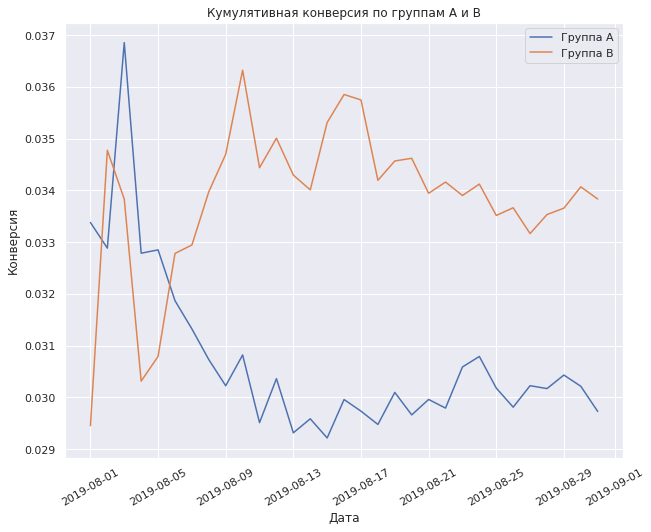

In [18]:
# Отделяем данные по группам
cumulative_conversion_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_conversion_b = cumulative_data[cumulative_data['group'] == 'B']

# Построение графика кумулятивной конверсии
plt.plot(
    cumulative_conversion_a['date'], 
    cumulative_conversion_a['conversion'], 
    label='Группа A'
)

plt.plot(
    cumulative_conversion_b['date'], 
    cumulative_conversion_b['conversion'], 
    label='Группа B'
)

plt.legend()
plt.title('Кумулятивная конверсия по группам A и B')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.xticks(rotation=30)
plt.grid(True)
plt.show()


График показывает, что конверсия группы B стабильно выше, чем у группы A, начиная с первых дней эксперимента. После начальных колебаний конверсия обеих групп стабилизировалась, с явным преимуществом группы B.

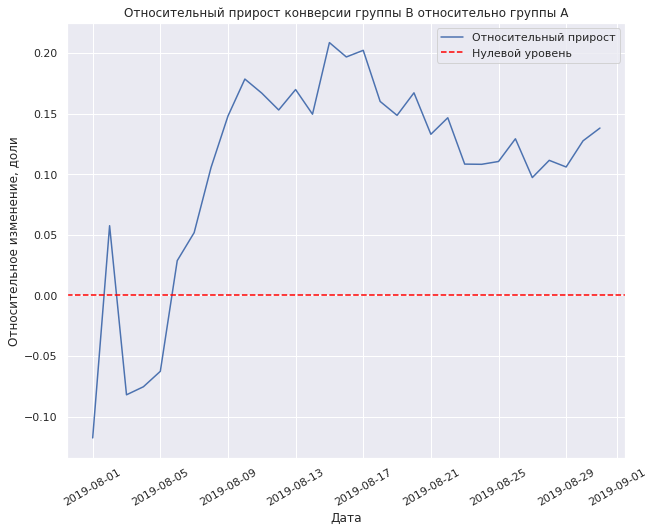

In [19]:
# Разделяем данные на группы A и B
cumulative_data_a = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_b = cumulative_data[cumulative_data['group'] == 'B']

# Объединение данных о кумулятивной конверсии для групп A и B
cumulative_conversion_comparison = (
    cumulative_data_a[['date', 'conversion']]
    .merge(
        cumulative_data_b[['date', 'conversion']], 
        on='date', 
        how='left', 
        suffixes=['_a', '_b']
    )
)

# Построение графика относительного прироста конверсии группы B относительно группы A
plt.plot(
    cumulative_conversion_comparison['date'], 
    cumulative_conversion_comparison['conversion_b'] / 
    cumulative_conversion_comparison['conversion_a'] - 1,
    label='Относительный прирост'
)

plt.axhline(y=0, color='red', linestyle='--', label='Нулевой уровень')

plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.ylabel('Относительное изменение, доли')
plt.xlabel('Дата')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.show()


График показывает, что в начале эксперимента наблюдались значительные колебания относительного прироста конверсии группы B по сравнению с группой A. После 5 августа прирост стабилизируется и удерживается на уровне около 15–20%. Это свидетельствует о значительном преимуществе группы B по сравнению с группой A.

Построим точечный график количества заказов по пользователям:

In [20]:
orders_per_user = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': 'nunique'}) \
                         .rename(columns={'transaction_id': 'orders'})

orders_per_user.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


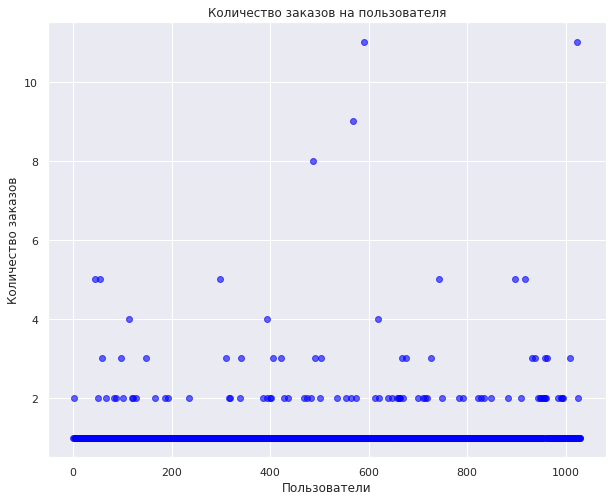

In [21]:
x_values = pd.Series(range(0, len(orders_per_user['orders'])))
plt.scatter(x_values, orders_per_user['orders'], color='blue', alpha=0.6)
plt.title('Количество заказов на пользователя')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

Большинство пользователей совершают 1–2 заказа. Однако наблюдаются выбросы — отдельные пользователи, которые совершили более 4 заказов. 

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя:

In [22]:
percentile_95 = np.percentile(orders_per_user['orders'], 95)
percentile_99 = np.percentile(orders_per_user['orders'], 99)

print(f'95-й перцентиль: {percentile_95:.2f}')
print(f'99-й перцентиль: {percentile_99:.2f}')


95-й перцентиль: 2.00
99-й перцентиль: 4.00


95-й перцентиль равен 2, что означает, что 95% пользователей совершают не более 2 заказов.
99-й перцентиль равен 4, то есть только 1% пользователей совершают 4 или более заказов.

Следовательно, пользователи с количеством заказов 4 и выше могут считаться аномальными и быть исключены из анализа.

**Построим точечный график стоимостей заказов:**

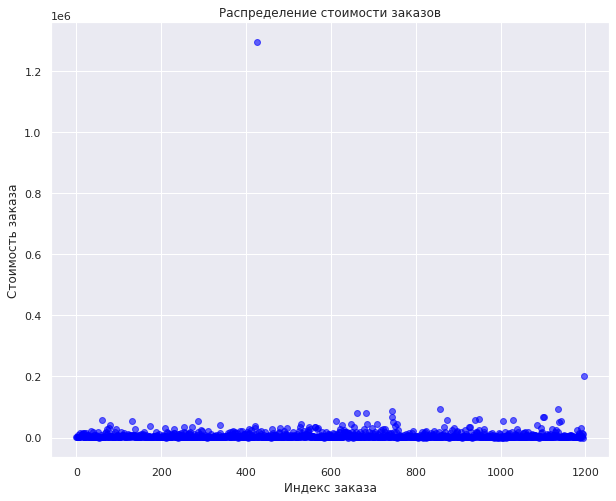

In [23]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], color='blue', alpha=0.6)

plt.title('Распределение стоимости заказов')
plt.xlabel('Индекс заказа')
plt.ylabel('Стоимость заказа')
plt.grid(True)
plt.show()


Большинство заказов имеют стоимость в пределах небольшой величины, однако присутствуют выбросы, включая один аномально дорогой заказ стоимостью более 1,2 млн. Эти выбросы могут существенно влиять на результаты анализа и требуют их учета для получения корректных выводов.

**Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов:**

In [24]:
percentile_95_revenue = np.percentile(orders['revenue'], 95)
percentile_99_revenue = np.percentile(orders['revenue'], 99)

print(f'95-й перцентиль стоимости заказов: {percentile_95_revenue:.2f}')
print(f'99-й перцентиль стоимости заказов: {percentile_99_revenue:.2f}')

# Определяем границу для аномальных заказов
anomaly_threshold = percentile_99_revenue
print(f'Граница для аномальных заказов: {anomaly_threshold:.2f}')


95-й перцентиль стоимости заказов: 28000.00
99-й перцентиль стоимости заказов: 58233.20
Граница для аномальных заказов: 58233.20


**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным:**


    
    Нулевая и альтернативная гипотезы:
    
**Нулевая гипотеза (H₀):** 
Среднее количество заказов на пользователя не отличается между группами A и B.

**Альтернативная гипотеза (H₁):**
Среднее количество заказов на пользователя отличается между группами A и B.

In [25]:
# Подготовка данных: количество заказов на пользователя по группам
orders_by_user_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'orders'})
)

orders_by_user_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
    .rename(columns={'transaction_id': 'orders'})
)

# Дополнение выборок нулями для учета пользователей, которые не сделали заказов
sample_a = pd.concat(
    [orders_by_user_a['orders'], 
     pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_user_a['orders'])))],
    axis=0
)

sample_b = pd.concat(
    [orders_by_user_b['orders'], 
     pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_user_b['orders'])))],
    axis=0
)

# Применение теста Манна-Уитни
p_value = mannwhitneyu(sample_a, sample_b, alternative='two-sided')[1]
mean_diff = sample_b.mean() - sample_a.mean()

print(f'P-value: {p_value:.4f}')
print(f'Средняя разница в количестве заказов на пользователя: {mean_diff:.4f}')

if p_value < 0.05:
    print('Между группами есть статистически значимые различия.')
else:
    print('Нет статистически значимых различий между группами.')
    
relative_increase = sample_b.mean() / sample_a.mean() - 1
print(f"Относительный прирост конверсии группы B относительно группы A составляет: {relative_increase:.2%}")


P-value: 0.0168
Средняя разница в количестве заказов на пользователя: 0.0041
Между группами есть статистически значимые различия.
Относительный прирост конверсии группы B относительно группы A составляет: 13.81%


Отвергаем нулевую гипотезу.

Конверсия группы B выше, и это различие является статистически значимым.

**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным:**

In [26]:
# Подготовка данных: выручка заказов для каждой группы
revenue_a = orders[orders['group'] == 'A']['revenue']
revenue_b = orders[orders['group'] == 'B']['revenue']

# Применение критерия Манна-Уитни
p_value = mannwhitneyu(revenue_a, revenue_b, alternative='two-sided')[1]
mean_diff = revenue_b.mean() - revenue_a.mean()

print(f'P-value: {p_value:.4f}')
print(f'Средняя разница в среднем чеке заказа между группами: {mean_diff:.2f}')

if p_value < 0.05:
    print('Между группами есть статистически значимые различия в среднем чеке заказа.')
else:
    print('Нет статистически значимых различий в среднем чеке заказа между группами.')


P-value: 0.7293
Средняя разница в среднем чеке заказа между группами: 1897.30
Нет статистически значимых различий в среднем чеке заказа между группами.


**Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным:**

In [27]:
# Пороги для фильтрации аномальных пользователей
order_threshold = np.percentile(orders_per_user['orders'], 99)  # Порог для количества заказов
revenue_threshold = np.percentile(orders['revenue'], 99)  # Порог для стоимости заказов

# Определим аномальных пользователей
high_order_users = orders_per_user[orders_per_user['orders'] > order_threshold]['visitor_id']
high_revenue_users = orders[orders['revenue'] > revenue_threshold]['visitor_id']

outliers = pd.concat([high_order_users, high_revenue_users]).drop_duplicates()

# Сформируем очищенные данные для группы A
filtered_sample_a = pd.concat([
    orders_by_user_a[orders_by_user_a['visitor_id'].isin(outliers) == False]['orders'],
    pd.Series(0, index=np.arange(visitors[visitors['group'] == 'A']['visitors'].sum() - len(orders_by_user_a['orders'])))
])

# Сформируем очищенные данные для группы B
filtered_sample_b = pd.concat([
    orders_by_user_b[orders_by_user_b['visitor_id'].isin(outliers) == False]['orders'],
    pd.Series(0, index=np.arange(visitors[visitors['group'] == 'B']['visitors'].sum() - len(orders_by_user_b['orders'])))
])

# Применение теста Манна-Уитни
p_value_filtered = mannwhitneyu(filtered_sample_a, filtered_sample_b, alternative='two-sided')[1]
mean_difference = filtered_sample_b.mean() - filtered_sample_a.mean()

print(f'P-value (очищенные данные): {p_value_filtered:.4f}')
print(f'Средняя разница в количестве заказов на пользователя (очищенные данные): {mean_difference:.4f}')

if p_value_filtered < 0.05:
    print('Между группами есть статистически значимые различия в среднем количестве заказов на пользователя (очищенные данные).')
else:
    print('Нет статистически значимых различий в среднем количестве заказов на пользователя между группами (очищенные данные).')

# Расчет относительного прироста группы B к группе A
relative_increase = sample_b.mean() / sample_a.mean() - 1
print(f'Относительный прирост группы B к группе A составляет: {relative_increase:.2%}')


P-value (очищенные данные): 0.0138
Средняя разница в количестве заказов на пользователя (очищенные данные): 0.0042
Между группами есть статистически значимые различия в среднем количестве заказов на пользователя (очищенные данные).
Относительный прирост группы B к группе A составляет: 13.81%


**Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным:**

In [28]:
#Сформируем очищенные данные для группы A (без аномалий)
filtered_revenue_a = orders[
    (orders['group'] == 'A') & 
    (orders['visitor_id'].isin(outliers) == False)
]['revenue']

# Сформируем очищенные данные для группы B (без аномалий)
filtered_revenue_b = orders[
    (orders['group'] == 'B') & 
    (orders['visitor_id'].isin(outliers) == False)
]['revenue']

# Применяем критерий Манна-Уитни
p_value_filtered = mannwhitneyu(filtered_revenue_a, filtered_revenue_b, alternative='two-sided')[1]
mean_diff_filtered = filtered_revenue_b.mean() - filtered_revenue_a.mean()

print(f'P-value (очищенные данные): {p_value_filtered:.4f}')

if p_value_filtered < 0.05:
    print('Между группами есть статистически значимые различия в среднем чеке заказа (очищенные данные).')
else:
    print('Нет статистически значимых различий в среднем чеке заказа между группами (очищенные данные).')


P-value (очищенные данные): 0.9575
Нет статистически значимых различий в среднем чеке заказа между группами (очищенные данные).


# Выводы и рекомендации по результатам A/B-теста

**Приоритизация гипотез**

- **Метод ICE**:
  - Наивысший приоритет у гипотезы 8 (скидка на день рождения).
  - Высокий приоритет также у гипотез 0, 7, 6 и 2.
- **Метод RICE**:
  - Гипотеза 7 выделена как наиболее перспективная за счет учета охвата (Reach).
  - Порядок приоритизации других гипотез изменился по сравнению с ICE.
- **Учет охвата** в методе RICE значительно влияет на приоритеты, что важно учитывать при выборе гипотез для реализации.
------
**Результаты теста по ключевым метрикам**

**Выручка**
- Кумулятивная выручка группы B стабильно выше группы A.
- Резкий скачок около 18 августа может быть вызван крупными заказами или выбросами.

**Средний чек**
- Средний чек группы A стабилен.
- В группе B наблюдаются скачки из-за крупных заказов.
- После учета выбросов **статистически значимых различий** в среднем чеке между группами **не выявлено**.

**Конверсия**
- Конверсия группы B стабильно выше группы A на протяжении всего теста.
- Относительный прирост конверсии группы B относительно группы A составляет **13.81%**.
- **Статистически значимые различия** в конверсии подтверждены как на «сырых» данных, так и после фильтрации аномалий.
-----
**Рекомендация**

На основании данных и анализа метрик предлагаем:

 - **Остановить тест и зафиксировать победу группы B** по следующим причинам:
   - Конверсия группы B значительно выше группы A (на **13.81%**) и это различие статистически значимо.
   - Средний чек не имеет статистически значимых различий между группами, но тестирование показало, что группа B обеспечивает стабильный рост конверсии.

 - Учитывая высокую конверсию группы B, **улучшения в привлечении пользователей** могут привести к значительному росту выручки.
